In [15]:
import os
import torch
import torchvision

from torchvision.io import read_image

from ShapeDataset import *

In [16]:
##### Defining some variables #####
num_classes = 3 + 1  # classes + background
classes = ['Background', 'Cube', 'Octahedron', 'Sphere']
hidden_layer = 256
data_dir = './Data'
annotations = os.path.join(data_dir,'_annotations.coco.json')

In [17]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

#### Defining the model ####
# load a object detection model pre-trained on the COCO dataset. 
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

in_features = model.roi_heads.box_predictor.cls_score.in_features # get number of input features for the classifier
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # replace the pre-trained head with a new one

def get_model_instance_segmentation(num_classes, hidden_layer):
    # load an instance segmentation model pre-trained on the COCO dataset
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    in_features = model.roi_heads.box_predictor.cls_score.in_features # get number of input features for the classifier
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)# replace the pre-trained head with a new one

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels # get the number of input features for the mask classifier
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )
    return model

In [18]:
from torchvision.transforms import v2

# Helper function for data augmentation
def get_transform(train):
    transforms = []
    if train:
        transforms.append(v2.RandomHorizontalFlip(0.5))
    transforms.append(v2.ToDtype(torch.float, scale=True))
    transforms.append(v2.ToPureTensor())
    return v2.Compose(transforms)

In [19]:
# Before iterating over the dataset, it's good to see what the model
# expects during training and inference time on sample data.
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = torchvision.datasets.wrap_dataset_for_transforms_v2(ShapeDataset(data_dir,annotations, get_transform(train=True)),target_keys=['image_id','area','iscrowd','labels','boxes','masks'])
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=utils.collate_fn
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [20]:
# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(3.7644, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.2955, grad_fn=<DivBackward0>), 'loss_objectness': tensor(1.3732, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0503, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


Let’s now write the main function which performs the training and the
validation:



In [21]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 4
# use our dataset and defined transformations
dataset      = torchvision.datasets.wrap_dataset_for_transforms_v2(ShapeDataset(data_dir,annotations, get_transform(train=True)),target_keys=['image_id','area','iscrowd','labels','boxes','masks'])
dataset_test = torchvision.datasets.wrap_dataset_for_transforms_v2(ShapeDataset(data_dir,annotations, get_transform(train=False)),target_keys=['image_id','area','iscrowd','labels','boxes','masks'])

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
split_ind = len(dataset)//10
dataset = torch.utils.data.Subset(dataset, indices[:-split_ind])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-split_ind:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes, hidden_layer)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Epoch: [0]  [ 0/14]  eta: 0:01:56  lr: 0.000389  loss: 10.3885 (10.3885)  loss_classifier: 1.5592 (1.5592)  loss_box_reg: 0.8739 (0.8739)  loss_mask: 3.4162 (3.4162)  loss_objectness: 4.3781 (4.3781)  loss_rpn_box_reg: 0.1611 (0.1611)  time: 8.3311  data: 0.1358
Epoch: [0]  [10/14]  eta: 0:00:31  lr: 0.004232  loss: 3.1936 (4.8152)  loss_classifier: 0.9759 (1.0467)  loss_box_reg: 0.6375 (0.6774)  loss_mask: 0.8465 (1.6158)  loss_objectness: 0.5172 (1.3282)  loss_rpn_box_reg: 0.1279 (0.1470)  time: 7.7939  data: 0.3968
Epoch: [0]  [13/14]  eta: 0:00:07  lr: 0.005000  loss: 3.1794 (4.6256)  loss_classifier: 0.9379 (1.0052)  loss_box_reg: 0.6373 (0.6417)  loss_mask: 0.8006 (1.4071)  loss_objectness: 0.4506 (1.4135)  loss_rpn_box_reg: 0.1172 (0.1581)  time: 7.4094  data: 0.3353
Epoch: [0] Total time: 0:01:43 (7.4098 s / it)


/Users/johannes/Documents/Uni/Semester7/MachineLearning/ml-project-2-andersmaxjohannes/engine.py:79: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


Test:  [0/2]  eta: 0:00:01  model_time: 0.6184 (0.6184)  evaluator_time: 0.0008 (0.0008)  time: 0.6221  data: 0.0029
Test:  [1/2]  eta: 0:00:00  model_time: 0.6154 (0.6169)  evaluator_time: 0.0008 (0.0016)  time: 0.6739  data: 0.0554
Test: Total time: 0:00:01 (0.6741 s / it)
Averaged stats: model_time: 0.6154 (0.6169)  evaluator_time: 0.0008 (0.0016)
Accumulating evaluation results...
DONE (t=0.00s).
Accumulating evaluation results...
DONE (t=0.00s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | ar

/Users/johannes/Documents/Uni/Semester7/MachineLearning/ml-project-2-andersmaxjohannes/testVenv/lib/python3.11/site-packages/torchvision/utils.py:209: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")
/Users/johannes/Documents/Uni/Semester7/MachineLearning/ml-project-2-andersmaxjohannes/testVenv/lib/python3.11/site-packages/torchvision/utils.py:303: UserWarning: masks doesn't contain any mask. No mask was drawn
  warnings.warn("masks doesn't contain any mask. No mask was drawn")


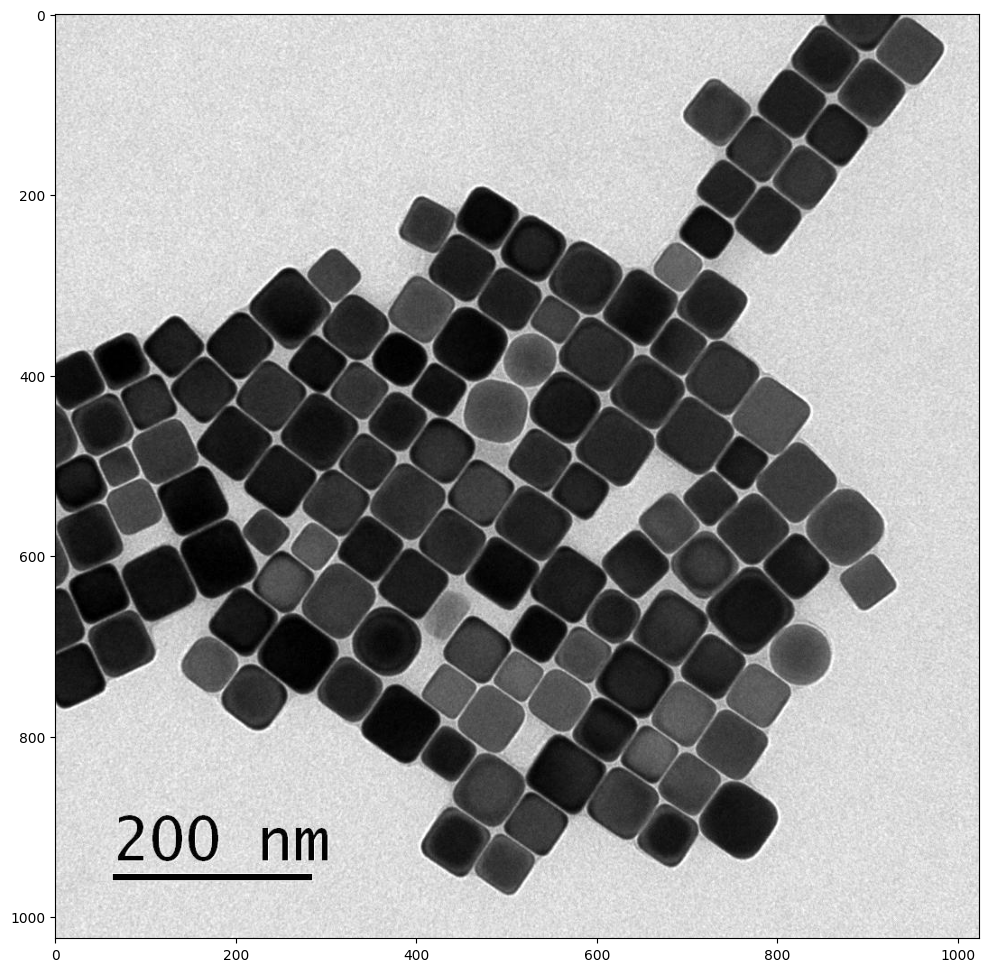

In [22]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image(os.path.join(data_dir,"Cu-s-16_0004_jpg.rf.21708722aff4c9b4c45354b87d9330e9.jpg"))
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"{label},{classes[label]}: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors='blue')


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

In [23]:
import numpy as np
def countInstances(labels,printout=False):
    instances = np.zeros(len(classes),dtype=np.int64)
    for i in range(len(labels)):
        image_int, trash = labels[i].split(',')
        for j in range(1,len(classes)):
            if int(image_int)==j:
                instances[j] += 1

    if printout:
        print('The number of detected instances of each shape in the selected image are:')
        for i in range(1,len(classes)):
            print(f'{classes[i]}:{instances[i]}')
    return instances

count = countInstances(pred_labels, printout=True)

The number of detected instances of each shape in the selected image are:
Cube:0
Octahedron:0
Sphere:0
